In [1]:
#!pip install qulacs
#!pip install matplotlib
#!pip install numpy
#!pip install scipy
from utility import *

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import time 
import random
from qulacs import QuantumState
from qulacs import QuantumCircuit
from qulacs.gate import DenseMatrix
from qulacs import Observable
from qulacs.circuit import QuantumCircuitOptimizer
from qulacs.gate import *
import math 

In [4]:
# 0,1基底での射影測定
def z_basis_projection(state,index):
    state_copy = state.copy()

    #射影測定のシミュレーション
    P0(index).update_quantum_state(state)
    prob = state.get_squared_norm()

    if np.random.random() > prob:
        outcome = 1
        state = state_copy
        P1(index).update_quantum_state(state)
        X(index).update_quantum_state(state)
        #１が出た時は0に初期化
        state.multiply_coef(1/np.sqrt(1-prob))
        return state, outcome, prob
        #規格化

    else:
        outcome = 0
        state.multiply_coef(1/np.sqrt(prob))
        #規格化
        return state, outcome, prob

# 位相推定アルゴリズム

ここでは、簡単のために、計算基底が固有状態となるイジングハミルトニアンに対する位相推定を用いて、位相推定について説明します。（とくにアルゴリズム的な優位性はないように思いますが、位相推定アルゴリズムそのものがIQPという特殊な回路クラスに入るので面白い応用があるかもしれません）

## ハミルトニアンの定義

In [5]:
nqubits = 5

#結合するペア
Ising_pairs = [[i,j] for i in range(nqubits) for j in range(nqubits) if i<j]

#結合定数
Ising_couplings = [2*np.random.randint(2)-1 for _ in Ising_pairs]

#磁場
z_fields = [2*np.random.randint(2)-1 for i in range(nqubits)]

print(Ising_couplings)

#ハミルトニアンの定義
Hamiltonian = Observable(nqubits)
for i in range(len(Ising_pairs)):
    Hamiltonian.add_operator(Ising_couplings[i],f"Z {Ising_pairs[i][0]} Z {Ising_pairs[i][1]}")      
for i in range(len(z_fields)):
    Hamiltonian.add_operator(z_fields[i],f"Z {i}")      
show_observable(Hamiltonian)

[1, 1, -1, 1, -1, -1, 1, 1, -1, -1]
(1+0j) Z0 Z1
(1+0j) Z0 Z2
(-1+0j) Z0 Z3
(1+0j) Z0 Z4
(-1+0j) Z1 Z2
(-1+0j) Z1 Z3
(1+0j) Z1 Z4
(1+0j) Z2 Z3
(-1+0j) Z2 Z4
(-1+0j) Z3 Z4
(-1+0j) Z0
(-1+0j) Z1
(-1+0j) Z2
(-1+0j) Z3
(-1+0j) Z4


#エネルギーをプロットしてみる

In [6]:
def show_energy_landscape(Hamiltonian):
    nqubits = Hamiltonian.get_qubit_count()
    state = QuantumState(nqubits)
    res = []
    for i in range(2**nqubits):
        state.set_computational_basis(i)
        res.append(Hamiltonian.get_expectation_value(state).real)

    plt.plot(res)
    plt.show()

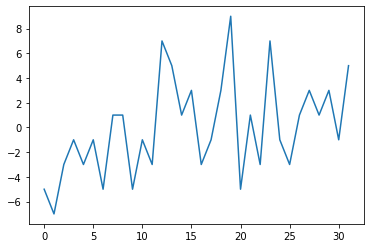

In [7]:
show_energy_landscape(Hamiltonian)

## ハミルトニアンダイナミクスの定義
ハミルトニアンダイナミクスを計算してみる：

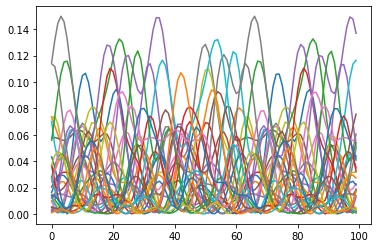

In [8]:
state = QuantumState(nqubits)
delta_t = 0.1
T=10.0
res = []

dynamics = QuantumCircuit(nqubits)
dynamics.add_observable_rotation_gate(Hamiltonian, delta_t, 1)

state.set_Haar_random_state()

for k in range(int(T/delta_t)):
    dynamics.update_quantum_state(state)
    state_copy =  state.copy()
    
    for i in range(nqubits):
        H(i).update_quantum_state(state_copy)

    res.append([abs(amp)**2 for amp in state_copy.get_vector()])

for k in range(2**nqubits):
    plt.plot([res[i][k] for i in range(len(res))])
plt.show()

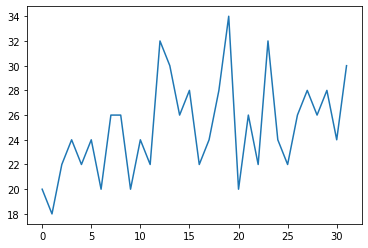

In [9]:
#エネルギーは、結合の総数、磁場の総数でバウンドされるので、補助量子ビットとしては、log2(2(nqubit^2 + nqubit))+α程度あればよい
#定数倍シフトをしておいてエネルギーを正にする
Hamiltonian.add_operator(nqubits*(nqubits-1)+nqubits,f"I {0}")      
show_energy_landscape(Hamiltonian)



In [10]:
from qulacs.gate import to_matrix_gate

def add_control_qubit_for_circuit(circuit,control_index,total_num_qubits):

    num_gate = circuit.get_gate_count()   
    control_circuit = QuantumCircuit(total_num_qubits)
    
    for i in range(num_gate):
        gate_tmp = circuit.get_gate(i)
        gate_tmp = to_matrix_gate(gate_tmp)
        gate_tmp.add_control_qubit(control_index,1) #新しく追加した nqubit番目の量子ビットを制御量子ビットとする
        control_circuit.add_gate(gate_tmp)

    return control_circuit



## １つの補助量子ビットを導入しアダマールテストを繰り返す

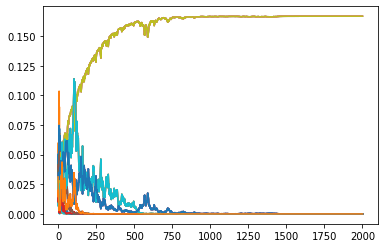

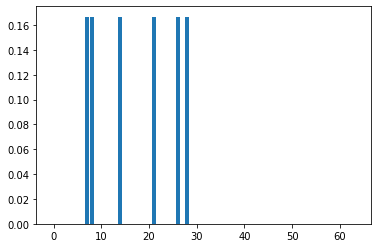

In [11]:
#とりえず、１量子ビットの補助量子ビットでエネルギーに関する連続測定（アダマールテストの繰り返し）をする
theta = 1.0*np.pi/(2*(nqubits*(nqubits-1)+nqubits))
num_step = 2000
res = []

dynamics = QuantumCircuit(nqubits)
dynamics.add_observable_rotation_gate(Hamiltonian,2*theta, 1)

controlled_dynamics = add_control_qubit_for_circuit(dynamics,nqubits,nqubits+1)
#control gateにする
#dynamics.add_control_qubit(nqubits,1)

state = QuantumState(nqubits+1)

#全ての状態の重ね合わせを作る
for i in range(nqubits):
    H(i).update_quantum_state(state)

res.append([abs(amp)**2 for amp in state.get_vector()])
    
#アダマールテストの繰り返し
for _ in range(num_step):
    H(nqubits).update_quantum_state(state)
    controlled_dynamics.update_quantum_state(state)
    H(nqubits).update_quantum_state(state)
    state_copy = state.copy()

    #射影測定のシミュレーション
    P0(nqubits).update_quantum_state(state)
    prob = state.get_squared_norm()

    if np.random.random() > prob:
        state = state_copy
        P1(nqubits).update_quantum_state(state)
        X(nqubits).update_quantum_state(state)
        #１が出た時は0に初期化
        state.multiply_coef(1/np.sqrt(1-prob))
        #規格化

    else:
        state.multiply_coef(1/np.sqrt(prob))
        #規格化
        
    res.append([abs(amp)**2 for amp in state.get_vector()])

for k in range(2**nqubits):
    plt.plot([res[i][k] for i in range(len(res))])
plt.show()

plt.bar([i for i in range(len(res[0]))],res[len(res)-1])
plt.show()



どのような状態に収束しているか確認しておく

In [12]:
ans = [i for i in range(2**nqubits) if abs(state.get_vector()[i])**2>0.01] 
new_state=QuantumState(nqubits)
for k in ans:
    new_state.set_computational_basis(k)
    print(Hamiltonian.get_expectation_value(new_state))

26.0
26.0
26.0
26.0
26.0
26.0


同じエネルギーの状態（縮退したエネルギー固有状態）が得られている。
ただし、収束するのに必要なステップ数は大きい。次に、補助量子ビットの数を増やし、量子位相推定を実行する。位相推定のサブルーチンで利用する制御位相ゲートおよび逆量子フーリエ変換を定義しておく。

## 量子位相推定の実装

In [13]:
#制御位相ゲート
def controlled_phase(tot_num_qubits,control_index, target_index,angle):
    circuit = QuantumCircuit(tot_num_qubits)
    controlled_phase_gate =to_matrix_gate( RZ(target_index,angle))
    controlled_phase_gate.add_control_qubit(control_index,1)
    circuit.add_gate(controlled_phase_gate)
    return circuit

#量子逆フーリエ変換
def inv_qft(state,num_reg_qubits,start_index):
    tot_num_qubits = state.get_qubit_count()
    
    for j in range(num_reg_qubits-1):
        H(j+start_index).update_quantum_state(state)
        for k in range(num_reg_qubits-1-j):
            circuit = controlled_phase(tot_num_qubits,j+start_index,j+start_index+1+k,1.0*np.pi/(2**(k+1)))
            circuit.update_quantum_state(state)
    H(tot_num_qubits-1).update_quantum_state(state)
    return state



まずは固有状態を入力して、きちんとエネルギーが得られているか検証しておく。

100


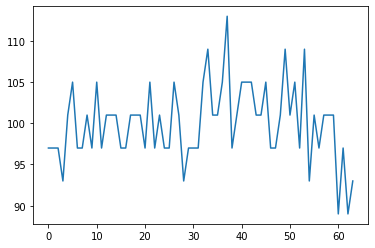

num_reg_qubits =  8
97.0 [97, 97, 97, 97, 97, 97, 97, 97, 97, 97]
97.0 [97, 97, 97, 97, 97, 97, 97, 97, 97, 97]
97.0 [97, 97, 97, 97, 97, 97, 97, 97, 97, 97]
93.0 [93, 93, 93, 93, 93, 93, 93, 93, 93, 93]
101.0 [101, 101, 101, 101, 101, 101, 101, 101, 101, 101]
105.0 [105, 105, 105, 105, 105, 105, 105, 105, 105, 105]
97.0 [97, 97, 97, 97, 97, 97, 97, 97, 97, 97]
97.0 [97, 97, 97, 97, 97, 97, 97, 97, 97, 97]
101.0 [101, 101, 101, 101, 101, 101, 101, 101, 101, 101]
97.0 [97, 97, 97, 97, 97, 97, 97, 97, 97, 97]
105.0 [105, 105, 105, 105, 105, 105, 105, 105, 105, 105]
97.0 [97, 97, 97, 97, 97, 97, 97, 97, 97, 97]
101.0 [101, 101, 101, 101, 101, 101, 101, 101, 101, 101]
101.0 [101, 101, 101, 101, 101, 101, 101, 101, 101, 101]
101.0 [101, 101, 101, 101, 101, 101, 101, 101, 101, 101]
97.0 [97, 97, 97, 97, 97, 97, 97, 97, 97, 97]
97.0 [97, 97, 97, 97, 97, 97, 97, 97, 97, 97]
101.0 [101, 101, 101, 101, 101, 101, 101, 101, 101, 101]
101.0 [101, 101, 101, 101, 101, 101, 101, 101, 101, 101]
101.0 [

In [105]:
#量子位相推定
nqubits = 6 #固有値を求めたい系の量子ビット数
alpha = 2 #固有値の精度を担保するための余分なビット数

########################
#問題の定義
#結合するペア
Ising_pairs = [[i,j] for i in range(nqubits) for j in range(nqubits) if i<j]

#結合定数
Ising_couplings = [2*np.random.randint(2)-1 for _ in Ising_pairs]

#磁場
z_fields = [2*np.random.randint(2)-1 for i in range(nqubits)]
#print(Ising_couplings)

#ハミルトニアンの定義
Hamiltonian = Observable(nqubits)
for i in range(len(Ising_pairs)):
    Hamiltonian.add_operator(Ising_couplings[i],f"Z {Ising_pairs[i][0]} Z {Ising_pairs[i][1]}")      
for i in range(len(z_fields)):
    Hamiltonian.add_operator(z_fields[i],f"Z {i}")      
    #show_observable(Hamiltonian)
    
#エネルギーは、結合の総数、磁場の総数でバウンドされるので、補助量子ビットとしては、log2(2(nqubit^2 + nqubit))+α程度あればよい
#定数倍シフトをしておいてエネルギーを正にする

enegy_shift = nqubits*(nqubits-1)+nqubits 
print(energy_shift)

Hamiltonian.add_operator(energy_shift ,f"I {0}")      
show_energy_landscape(Hamiltonian)
########################


########################
#　補助量子ビットのビット数（精度）の決定
num_reg_qubits = int(math.log2(2*enegy_shift))+alpha #位相推定のビット精度
tot_num_qubits = num_reg_qubits + nqubits
print("num_reg_qubits = ",num_reg_qubits)

theta = 2.0*np.pi/ (2**num_reg_qubits)
########################

res = []

########################
# control化されたハミルトニアンダイナミクスの回路のリストを生成

dynamics = QuantumCircuit(nqubits)

controlled_dynamics_list = []

for k in range(num_reg_qubits):
    dynamics = QuantumCircuit(nqubits)
    dynamics.add_observable_rotation_gate(Hamiltonian,(2**(num_reg_qubits-k))*theta,1)
    controlled_dynamics = add_control_qubit_for_circuit(dynamics,nqubits+k,tot_num_qubits)
    controlled_dynamics_list.append(controlled_dynamics)
########################

#initial state
state = QuantumState(tot_num_qubits)

for input_state in range(2**nqubits):
    #検証のために初期状態を計算基底にとりエネルギーが得られているか調べよう
    state.set_computational_basis(input_state)

    #initial state preparation for ancilla
    for i in range(num_reg_qubits):
        H(i+nqubits).update_quantum_state(state)

    #controlled unitary
    for k in range(num_reg_qubits):
        controlled_dynamics_list[k].update_quantum_state(state)

    #quantum fourier transform
    state = inv_qft(state,num_reg_qubits,nqubits)

    #とりあえず10個測定結果をサンプリング
    outcome = state.sampling(10)
    #print([bin(y) for y in outcome])
    
    #位相推定のための補助量子ビットのみの測定結果を残す
    outcome = [round((x-x%(2**nqubits))/(2**nqubits)) for x in outcome]
    
    #エネルギーの値に換算する
    outcome = [round(2*np.pi*x/(2**(num_reg_qubits))/theta) for x in outcome]
    #print([bin(y) for y in outcome])
    
    #初期状態に対する期待値を計算しておいて一致しいているか確認
    state_answer = QuantumState(nqubits)
    state_answer.set_computational_basis(input_state)
    print(Hamiltonian.get_expectation_value(state_answer),outcome)

最後に、重ね合わせ状態を入力として実際に補助量子ビットを射影測定して、量子位相推定が機能するか検証する。

100


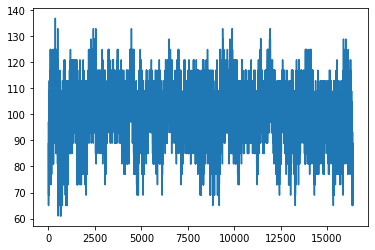

num_reg_qubits =  10
measurement outcome (inverse order!!) [1, 0, 0, 0, 1, 1, 1, 0, 0, 0]
energy　expectation value 112.9999999999998 energy phase estimation 113


In [109]:
#量子位相推定
nqubits = 14 #固有値を求めたい系の量子ビット数
alpha = 2 #固有値の精度を担保するための余分なビット数

########################
#問題の定義
#結合するペア
Ising_pairs = [[i,j] for i in range(nqubits) for j in range(nqubits) if i<j]

#結合定数
Ising_couplings = [2*np.random.randint(2)-1 for _ in Ising_pairs]

#磁場
z_fields = [2*np.random.randint(2)-1 for i in range(nqubits)]
#print(Ising_couplings)

#ハミルトニアンの定義
Hamiltonian = Observable(nqubits)
for i in range(len(Ising_pairs)):
    Hamiltonian.add_operator(Ising_couplings[i],f"Z {Ising_pairs[i][0]} Z {Ising_pairs[i][1]}")      
for i in range(len(z_fields)):
    Hamiltonian.add_operator(z_fields[i],f"Z {i}")      
    #show_observable(Hamiltonian)
    
#エネルギーは、結合の総数、磁場の総数でバウンドされるので、補助量子ビットとしては、log2(2(nqubit^2 + nqubit))+α程度あればよい
#定数倍シフトをしておいてエネルギーを正にする

enegy_shift = nqubits*(nqubits-1)+nqubits 
print(energy_shift)

Hamiltonian.add_operator(energy_shift ,f"I {0}")      
show_energy_landscape(Hamiltonian)
########################

########################
#　補助量子ビットのビット数（精度）の決定
num_reg_qubits = int(math.log2(2*enegy_shift))+alpha #位相推定のビット精度
tot_num_qubits = num_reg_qubits + nqubits
print("num_reg_qubits = ",num_reg_qubits)

theta = 2.0*np.pi/ (2**num_reg_qubits)
########################

#######################
#後の答えの検証のために補助系もいれたハミルトニアンも定義しておく
Hamiltonian_ancilla = Observable(tot_num_qubits)
for i in range(len(Ising_pairs)):
    Hamiltonian_ancilla.add_operator(Ising_couplings[i],f"Z {Ising_pairs[i][0]} Z {Ising_pairs[i][1]}")      
for i in range(len(z_fields)):
    Hamiltonian_ancilla.add_operator(z_fields[i],f"Z {i}")      
    #show_observable(Hamiltonian)
    
#エネルギーは、結合の総数、磁場の総数でバウンドされるので、補助量子ビットとしては、log2(2(nqubit^2 + nqubit))+α程度あればよい
#定数倍シフトをしておいてエネルギーを正にする

enegy_shift = nqubits*(nqubits-1)+nqubits 
#print(energy_shift)

Hamiltonian_ancilla.add_operator(energy_shift ,f"I {0}")      
#show_energy_landscape(Hamiltonian_ancilla)
########################

res = []

########################
# control化されたハミルトニアンダイナミクスの回路のリストを生成

dynamics = QuantumCircuit(nqubits)

controlled_dynamics_list = []

for k in range(num_reg_qubits):
    dynamics = QuantumCircuit(nqubits)
    dynamics.add_observable_rotation_gate(Hamiltonian,(2**(num_reg_qubits-k))*theta,1)
    controlled_dynamics = add_control_qubit_for_circuit(dynamics,nqubits+k,tot_num_qubits)
    controlled_dynamics_list.append(controlled_dynamics)
########################

#initial state
state = QuantumState(tot_num_qubits)

#位相推定の初期状態
for i in range(nqubits):
    H(i).update_quantum_state(state)

#initial state preparation for ancilla
for i in range(num_reg_qubits):
    H(i+nqubits).update_quantum_state(state)

#controlled unitary
for k in range(num_reg_qubits):
    controlled_dynamics_list[k].update_quantum_state(state)

#quantum fourier transform
state = inv_qft(state,num_reg_qubits,nqubits)

outcome = []
for i in range(num_reg_qubits):
    res = z_basis_projection(state,nqubits+i)
    state = res[0] # state
    outcome.append(res[1]) # measurement outcome
    
print("measurement outcome (inverse order!!)",outcome)

outcome_int = sum([2**k*outcome[k] for k in range(len(outcome))])
print("energy　expectation value",Hamiltonian_ancilla.get_expectation_value(state),"energy phase estimation",round(2*np.pi*outcome_int/(2**(num_reg_qubits))/theta))

## 発展編
- 上記の計算を一般のハミルトニアンで実行してみよう。このとき正しいエネルギー固有値が得られるか調べてみよう。
- 上記の実装では、位相推定に必要な補助量子ビットをすべて実際に確保したが、１つの補助量子ビットによって全く同じ回路を実行できる。補助量子ビットが1量子ビット版の量子位相推定を実装せよ。